In [187]:
import ampligraph
from ampligraph.datasets import load_from_ntriples
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx, save_model, restore_model

from rdflib import Graph, URIRef
from rdflib.namespace import RDF, OWL

import numpy as np
np.set_printoptions(threshold=100)

import random
np.random.seed(1) #0 before
random.seed(1)

In [188]:
# Create a new graph with the explicit triplets

def create_explicit_graph(graph, explicit_owlThings=False, is_correctness=True):
    new_g = Graph()
    statements = set()
    triplets = set()
    all_statements = []
    
    if is_correctness:
        true_entities = set()
        false_entities = set()
        truth_dico = {}
        hasTruthValue = URIRef("http://swc2017.aksw.org/hasTruthValue")
    
    OWLthing = URIRef("http://www.w3.org/2002/07/owl#Thing")

    chevr = lambda s : '<' + s + '>'
    
    # Iterate through statements
    for i,s in enumerate(graph.subjects(RDF.type, RDF.Statement)):
        statements.add(s)

        # Get <s> <p> <o>
        suj = graph.value(s, RDF.subject)
        pred = graph.value(s, RDF.predicate)
        obj = graph.value(s, RDF.object)
        
        # If the graph file have information on the correctess of statement (for the train set)
        if is_correctness:
            is_true = graph.value(s, hasTruthValue)
            # Save entities in false and true statements
            if float(is_true) == 1.0:
                true_entities.add(suj)
                true_entities.add(obj)
            elif float(is_true) == 0.0:
                false_entities.add(suj)
                false_entities.add(obj)
            
            # Save the truth of statement with a dictionnary
            if (suj, pred, obj) not in triplets:
                truth_dico[(chevr(str(suj)), chevr(str(pred)), chevr(str(obj)))] = float(is_true)
                #is_true_v.append(float(is_true))
        
        
            
        # Adding triplet to explicit graph and set of triplets
        new_g.add((suj, pred, obj))
        triplets.add((suj, pred, obj))
        
        # Add all statements, even if duplicate (for test set)
        all_statements.append([chevr(str(suj)), chevr(str(pred)), chevr(str(obj)), chevr(str(s))])

        # Make statements that subjects and predicates are owlthings (it is needed for rdf2vec)
        if explicit_owlThings:
            new_g.add((suj, RDF.type, OWLthing))
            new_g.add((obj, RDF.type, OWLthing))
    
    if is_correctness:
        return new_g, statements, triplets, true_entities, false_entities, truth_dico
    else:
        return new_g, triplets, all_statements

In [189]:
# Import raw training and test graph
g_train_raw = Graph()
g_train_raw.parse("SWC_2019_Train.nt", format="nt")
g_test_raw = Graph()
g_test_raw.parse("SWC_2019_Test.nt", format="nt")

<Graph identifier=N3e9e3bf406c24ce28ede74c58c2cc7a2 (<class 'rdflib.graph.Graph'>)>

In [190]:
g_train, statements_train, triplets_train, true_entities_train, false_entities_train, truth_dict_train = create_explicit_graph(g_train_raw, explicit_owlThings=False)
g_test, triplets_test, test_all_statements = create_explicit_graph(g_test_raw, explicit_owlThings=False, is_correctness=False)

In [191]:
# It seems that some entities are specific to correct and false statements
print(len(true_entities_train), len(false_entities_train))
print(len(true_entities_train.union(false_entities_train)))

8231 9976
11990


In [192]:
# Some statements seem to be equivalents
print(len(statements_train))
print(len(triplets_train))
print(len(g_train))

25000
23928
23928


In [193]:
# Save rdflib graphs into nt files
g_train.serialize(destination='trainGraphExplicit.nt', format="nt")

In [194]:
# Load Graph with Ampligraph
triplets_data_train = load_from_ntriples("/home/mondeca/Documents/FactTriplesChecker", "trainGraphExplicit.nt")
print(triplets_data_train.shape)
print(triplets_data_train[:4,:])

(23928, 3)
[['<http://dice-research.org/ns/drugbank#drug-DB12628>'
  '<http://dice-research.org/ontology/drugbank/hasIndication>'
  '<http://dice-research.org/ns/drugbank#disease-DS001685>']
 ['<http://dice-research.org/ns/drugbank#drug-DB09234>'
  '<http://dice-research.org/ontology/drugbank/interactsWith>'
  '<http://dice-research.org/ns/drugbank#drug-DB09269>']
 ['<http://dice-research.org/ns/drugbank#drug-DB10700>'
  '<http://dice-research.org/ontology/drugbank/hasCommonIndication>'
  '<http://dice-research.org/ns/drugbank#drug-DB08998>']
 ['<http://dice-research.org/ns/drugbank#drug-DB07723>'
  '<http://dice-research.org/ontology/drugbank/hasSameState>'
  '<http://dice-research.org/ns/drugbank#drug-DB10982>']]


In [195]:
# Load test data
test_data = np.array(test_all_statements)

In [196]:
# Get truth value of each statement from dictionnary and put in in a vector
truth_vect_train = []
for i,x in enumerate(triplets_data_train):
    is_true = truth_dict_train[tuple(x)]
    truth_vect_train.append(is_true)

In [197]:
# Combine array of statements and array of truth values
print(np.array(truth_vect_train).shape)
train_data = np.hstack((triplets_data_train, np.reshape(np.array(truth_vect_train), (len(triplets_train),1))))
print(train_data[:4,:])

(23928,)
[['<http://dice-research.org/ns/drugbank#drug-DB12628>'
  '<http://dice-research.org/ontology/drugbank/hasIndication>'
  '<http://dice-research.org/ns/drugbank#disease-DS001685>' 0.0]
 ['<http://dice-research.org/ns/drugbank#drug-DB09234>'
  '<http://dice-research.org/ontology/drugbank/interactsWith>'
  '<http://dice-research.org/ns/drugbank#drug-DB09269>' 1.0]
 ['<http://dice-research.org/ns/drugbank#drug-DB10700>'
  '<http://dice-research.org/ontology/drugbank/hasCommonIndication>'
  '<http://dice-research.org/ns/drugbank#drug-DB08998>' 0.0]
 ['<http://dice-research.org/ns/drugbank#drug-DB07723>'
  '<http://dice-research.org/ontology/drugbank/hasSameState>'
  '<http://dice-research.org/ns/drugbank#drug-DB10982>' 0.0]]


In [199]:
# Splitting training graph into train/valid set
train, valid = train_test_split_no_unseen(train_data, test_size=int(0.25 * train_data.shape[0]), seed=0)
print(train.shape, valid.shape)

# Save explicit statements with their binary labels, for train and development data
np.save("dev/trainDev", train)
np.save("dev/valid", valid)

# Save explicit statements for train+dev data and test data
np.save("test/train", train_data)
np.save("test/test", test_data)

(18537, 4) (5982, 4)


In [146]:
from ampligraph.latent_features import ComplEx, DistMult, TransE, HolE
from ampligraph.evaluation import evaluate_performance, mrr_score, hits_at_n_score

# Train an embedding model and save it
def train_save_model(train_data, model_name, nbatches, epochs, k, eta):
    model = model_name(batches_count=nbatches, seed=0, epochs=epochs, k=k, eta=eta,
                    # Use adam optimizer with learning rate 1e-3
                    optimizer='adam', optimizer_params={'lr':1e-3},
                    # Use pairwise loss with margin 0.5
                    loss='pairwise', loss_params={'margin':0.5},
                    # Use L2 regularizer with regularizer weight 1e-5
                    regularizer='LP', regularizer_params={'p':2, 'lambda':1e-5}, 
                    # Enable stdout messages (set to false if you don't want to display)
                    verbose=False)
        
    #Training
    model.fit(train_data[:,:3])
    
    fn = "./ampligraphModels/" + model_name.__name__ + "_" + str(k) +"_"+ str(epochs) +"_"+ str(eta)
    save_model(model, fn)

In [147]:
# Some good parameters : epochs = 200, k = 150, eta = 1
train_save_model(train_data, TransE, nbatches=10, epochs=200, k=150, eta=1)
train_save_model(train_data, DistMult, nbatches=10, epochs=200, k=150, eta=1)
train_save_model(train_data, HolE, nbatches=10, epochs=200, k=150, eta=1)
train_save_model(train_data, ComplEx, nbatches=10, epochs=200, k=150, eta=1)

2019-06-14 17:49:06,357 - ampligraph.latent_features.models - INFO - Using all entities for generation of corruptions
2019-06-14 17:50:45,003 - ampligraph.latent_features.models - INFO - Using all entities for generation of corruptions
2019-06-14 17:52:22,737 - ampligraph.latent_features.models - INFO - Using all entities for generation of corruptions
2019-06-14 17:56:19,563 - ampligraph.latent_features.models - INFO - Using all entities for generation of corruptions


In [148]:
# TRANSR algorithm
import pykeen
import os
from pykeen.kge_models import TransR
TransR.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'relation_embedding_dim',
 'scoring_function']

In [149]:
# Get output directory
output_directory = os.getcwd() + "/transRmodel"
print(output_directory)

/home/mondeca/Documents/FactTriplesChecker/transRmodel


In [150]:
config = dict(
    training_set_path           = './trainGraphExplicit.nt',
    execution_mode              = 'Training_mode',
    random_seed                 = 0,
    kg_embedding_model_name     = 'TransR',
    embedding_dim               = 150,
    relation_embedding_dim      = 150,
    scoring_function            = 2,  # corresponds to L2
    margin_loss                 = 0.5,
    learning_rate               = 1e-3,
    num_epochs                  = 200,  
    batch_size                  = 10,
    preferred_device            = 'cpu'
)

In [151]:
# Training
results = pykeen.run(
    config=config,
    output_directory=output_directory,
)

2019-06-14 18:09:00,735 - pykeen.utilities.pipeline - INFO - -------------Train KG Embeddings-------------


Training epoch: 100%|██████████| 200/200 [2:24:16<00:00, 43.16s/it]


In [152]:
results.results.keys()

odict_keys(['trained_model', 'losses', 'entity_to_embedding', 'relation_to_embedding', 'entity_to_id', 'relation_to_id', 'final_configuration'])

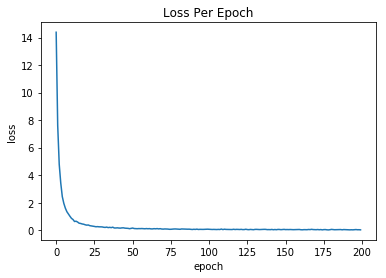

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

losses = results.results['losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()